# 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation 

Load modules and data

In [41]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Boston = pd.read_csv('Data/Boston.csv')

Load predefined functions

In [25]:
def getBest(X,y,k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(X,y,combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def processSubset(X,y,feature_set):
    # Fit model on feature_set and calculate RSS
    X = sm.add_constant(X[list(feature_set)])
    model = sm.OLS(y,X)
    regr = model.fit()
    RSS = ((regr.predict(X) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS, "coeff":regr.params}

### Setup data sets

In [26]:
#setup data set for validation set approach
train = np.random.choice([True, False], len(Boston), replace = True)
X_train = Boston[train].drop('medv', axis=1)
y_train = Boston[train].medv
X_test  = Boston[~train].drop('medv', axis=1)
y_test  = Boston[~train].medv
X_all   = Boston.drop('medv', axis=1)
y_all   = Boston.medv
#setup data set for cross validation
k= 10
folds = np.random.choice(range(1,k+1), len(Boston), replace = True)

### Subset selection with validation set approach

In [192]:
MSE_Val  = np.zeros((13,1))
Std_Val = np.zeros((13,1))
# Sub select 13 models and do prediction using the test data and calculate MSE for each model 
for i in range(1,14):
    coefi = getBest(X_train,y_train,i)["coeff"]
    pred = np.sum(X_test[coefi.index[1:]]*coefi[1:],axis=1)+coefi[0]
    MSE_Val[i-1]  = np.mean((y_test-pred)**2)
    Std_Val[i-1]  = np.std((y_test-pred))

('Processed ', 13, 'models on', 1, 'predictors in', 0.034999847412109375, 'seconds.')
('Processed ', 78, 'models on', 2, 'predictors in', 0.21399998664855957, 'seconds.')
('Processed ', 286, 'models on', 3, 'predictors in', 0.7179999351501465, 'seconds.')
('Processed ', 715, 'models on', 4, 'predictors in', 1.8229999542236328, 'seconds.')
('Processed ', 1287, 'models on', 5, 'predictors in', 3.6679999828338623, 'seconds.')
('Processed ', 1716, 'models on', 6, 'predictors in', 4.684000015258789, 'seconds.')
('Processed ', 1716, 'models on', 7, 'predictors in', 5.128000020980835, 'seconds.')
('Processed ', 1287, 'models on', 8, 'predictors in', 3.8899998664855957, 'seconds.')
('Processed ', 715, 'models on', 9, 'predictors in', 2.255000114440918, 'seconds.')
('Processed ', 286, 'models on', 10, 'predictors in', 0.7560000419616699, 'seconds.')
('Processed ', 78, 'models on', 11, 'predictors in', 0.2239999771118164, 'seconds.')
('Processed ', 13, 'models on', 12, 'predictors in', 0.0319998

In [193]:
#Find index for the min. MSE
p = np.where(MSE_Val==min(MSE_Val))[0]+1 # because zero index
print(p)

[[ 35.2464825 ]
 [ 34.18236799]
 [ 26.27129757]
 [ 27.8541313 ]
 [ 28.00258884]
 [ 26.72346079]
 [ 27.83012646]
 [ 26.77108683]
 [ 24.69240326]
 [ 24.90685642]
 [ 22.74544934]
 [ 22.93606083]
 [ 23.04698762]]
[11]
[[ 5.91327538]
 [ 5.77772899]
 [ 5.07329381]
 [ 5.15567749]
 [ 5.1417519 ]
 [ 5.02140002]
 [ 5.07393966]
 [ 4.97918502]
 [ 4.7988209 ]
 [ 4.85860483]
 [ 4.66606149]
 [ 4.6872773 ]
 [ 4.69570943]]


Now that we have found the amount of predictors, we shall redo the sub selection using only p predictors

In [194]:
coefi = getBest(X_all,y_all,p)["coeff"]
print(coefi)

('Processed ', 78, 'models on', array([11], dtype=int64), 'predictors in', 0.22699999809265137, 'seconds.')
const      36.341145
crim       -0.108413
zn          0.045845
chas        2.718716
nox       -17.376023
rm          3.801579
dis        -1.492711
rad         0.299608
tax        -0.011778
ptratio    -0.946525
black       0.009291
lstat      -0.522553
dtype: float64


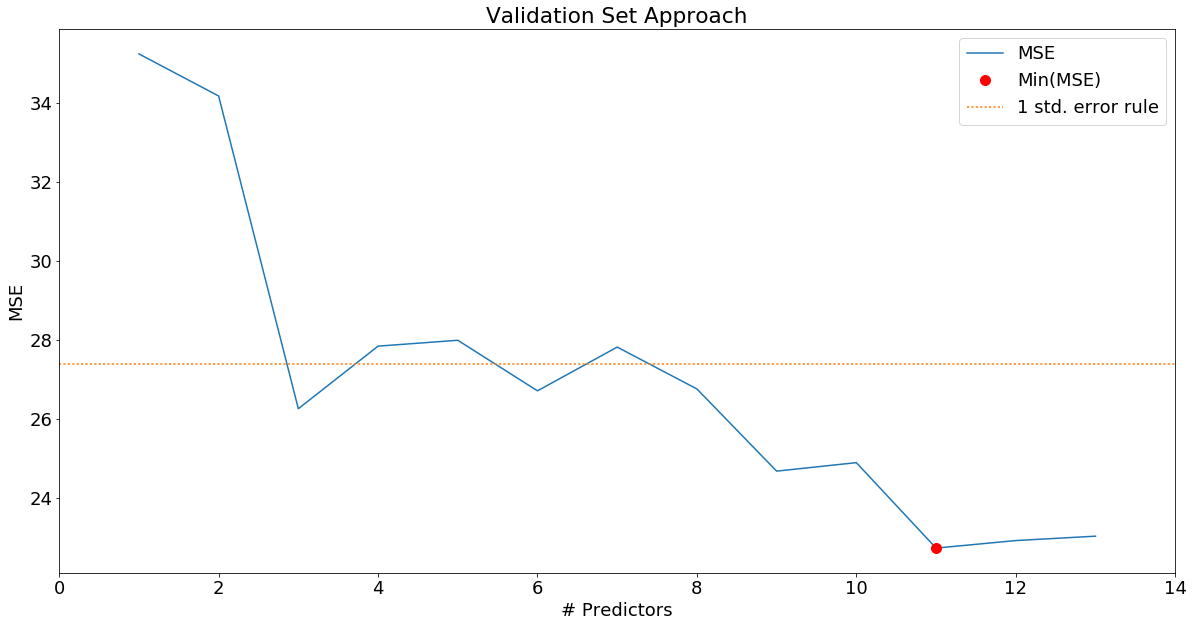

In [218]:
plt.figure(figsize=(20,10))
xaxis=range(1,14)
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})
plt.plot(xaxis,MSE_Val)
plt.plot(MSE_Val.argmin()+1, MSE_Val.min(), "or")
plt.plot([0,14], [Std_Val[p-1,0],Std_Val[p-1,0]]+MSE_Val.min(),":")
plt.xlabel('# Predictors')
plt.ylabel('MSE')
plt.title('Validation Set Approach')
plt.legend(["MSE","Min(MSE)","1 std. error rule"])
plt.xlim([0, 14])
plt.savefig('validationSet.png', dpi=600)

### Subset selection with cross validation

In [219]:
MSE_Val = np.zeros((k, 13))
std_Val = np.zeros((k, 13))
for j in range(1,k+1):
    for i in range(1,14):
        coefi = getBest(X_all[(folds != j)],y_all[(folds != j)],i)["coeff"]
        pred = np.sum(X_all[(folds == j)][coefi.index[1:]]*coefi[1:],axis=1)+coefi[0]
        MSE_Val[j-1,i-1] = np.mean((y_all[(folds == j)]-pred)**2)
        std_Val[j-1,i-1] = np.std((y_all[(folds == j)]-pred))
    print(j)

('Processed ', 13, 'models on', 1, 'predictors in', 0.03699994087219238, 'seconds.')
('Processed ', 78, 'models on', 2, 'predictors in', 0.18199992179870605, 'seconds.')
('Processed ', 286, 'models on', 3, 'predictors in', 0.7249999046325684, 'seconds.')
('Processed ', 715, 'models on', 4, 'predictors in', 1.9730000495910645, 'seconds.')
('Processed ', 1287, 'models on', 5, 'predictors in', 3.745000123977661, 'seconds.')
('Processed ', 1716, 'models on', 6, 'predictors in', 5.246999979019165, 'seconds.')
('Processed ', 1716, 'models on', 7, 'predictors in', 5.253000020980835, 'seconds.')
('Processed ', 1287, 'models on', 8, 'predictors in', 4.238000154495239, 'seconds.')
('Processed ', 715, 'models on', 9, 'predictors in', 2.240000009536743, 'seconds.')
('Processed ', 286, 'models on', 10, 'predictors in', 0.8469998836517334, 'seconds.')
('Processed ', 78, 'models on', 11, 'predictors in', 0.2239999771118164, 'seconds.')
('Processed ', 13, 'models on', 12, 'predictors in', 0.0320000648

In [220]:
# Take the mean of MSE each cross validation pr. model
mean_MSE = np.mean(MSE_Val,axis=0)
mean_std = np.mean(std_Val,axis=0)
p = np.where(mean_MSE==min(mean_MSE))[0]+1 # because zero index
print(p)

[11]


In [221]:
coefi = getBest(X_all,y_all,p)["coeff"]
print(coefi)

('Processed ', 78, 'models on', array([11], dtype=int64), 'predictors in', 0.26399993896484375, 'seconds.')
const      36.341145
crim       -0.108413
zn          0.045845
chas        2.718716
nox       -17.376023
rm          3.801579
dis        -1.492711
rad         0.299608
tax        -0.011778
ptratio    -0.946525
black       0.009291
lstat      -0.522553
dtype: float64


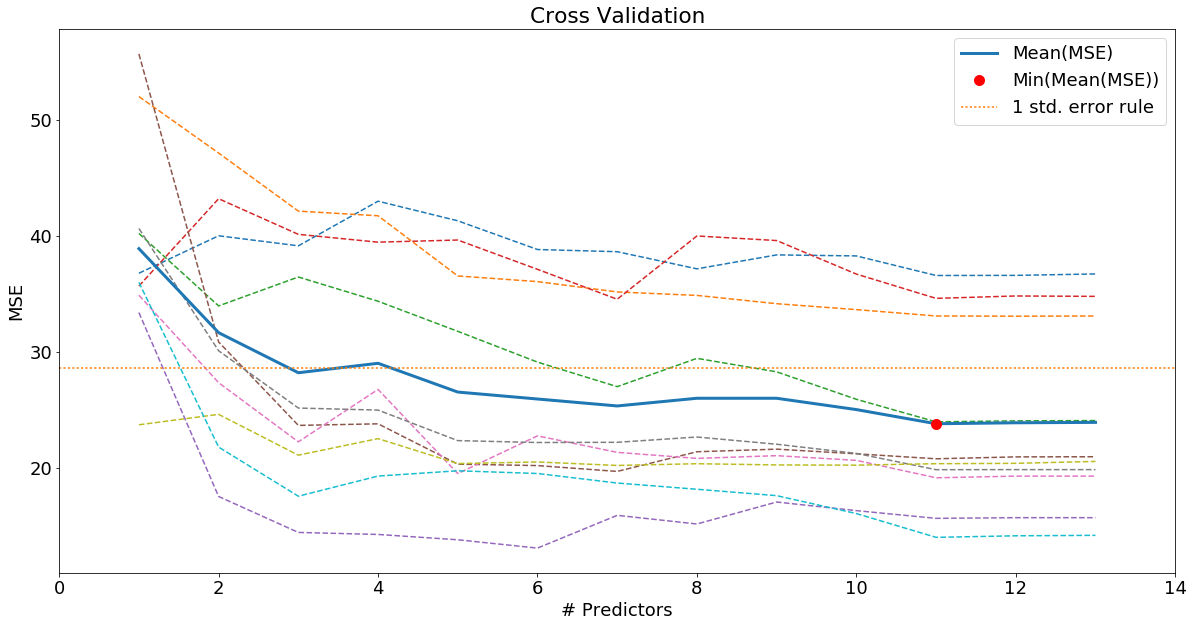

In [234]:
plt.figure(figsize=(20,10))
xaxis=range(1,14)
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})
plt.plot(xaxis,np.transpose(MSE_Val),'--',label=None)
axis=plt.plot(xaxis,mean_MSE,label="Mean(MSE)")
plt.setp(axis, 'linewidth', 3.0)
plt.plot(mean_MSE.argmin()+1, mean_MSE.min(), "or",label="Min(Mean(MSE))")
plt.plot([0,14], [mean_std[p-1],mean_std[p-1]]+mean_MSE.min(),":",label="1 std. error rule")
plt.xlabel('# Predictors')
plt.ylabel('MSE')
plt.title('Cross Validation')
plt.legend()
plt.xlim([0, 14])
plt.savefig('CrossValidation.png', dpi=600)